In [1]:
import yfinance as yf
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
def get_historical_data(ticker_symbol, start_date, end_date):

    # Create a ticker object
    ticker = yf.Ticker(ticker_symbol)

    # Get historical data for the specified date range
    historical_data = ticker.history(start=start_date, end=end_date)

    # Add a 'Ticker' column with the ticker symbol
    historical_data['Ticker'] = ticker_symbol

    # Reset the index to have the date as a column
    historical_data.reset_index(inplace=True)

    return historical_data


In [3]:
start_date = datetime.datetime(1960, 1, 1)
end_date = datetime.datetime(2024, 12, 31)

In [4]:
ticker_symbols  = ['AAPL', 'AMZN', 'TSLA', 'MSFT', 'GOOGL', 'META', 'JPM', 'JNJ', 'XOM', 'NVDA', 'GE','KO', 'F', 'IBM', 'PG', 'MMM', 'AXP', 'CVX', 'T', 'MCD', '^GSPC', '^DJI', '^IXIC','^RUT']

In [5]:
len(ticker_symbols)

24

In [6]:
all_historical_data = []
for symbol in ticker_symbols:
    # Get historical data for the current ticker symbol
    historical_data = get_historical_data(symbol, start_date, end_date)
    
    # Append the historical data for the current ticker symbol to the list
    all_historical_data.append(historical_data)

# Concatenate all historical data into a single DataFrame
combined_data = pd.concat(all_historical_data, ignore_index=True)
combined_data.to_csv('data2.csv', index=False)
# Display the combined data
combined_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,1980-12-12 00:00:00-05:00,0.099192,0.099623,0.099192,0.099192,469033600,0.0,0.0,AAPL
1,1980-12-15 00:00:00-05:00,0.094448,0.094448,0.094017,0.094017,175884800,0.0,0.0,AAPL
2,1980-12-16 00:00:00-05:00,0.087548,0.087548,0.087117,0.087117,105728000,0.0,0.0,AAPL
3,1980-12-17 00:00:00-05:00,0.089273,0.089704,0.089273,0.089273,86441600,0.0,0.0,AAPL
4,1980-12-18 00:00:00-05:00,0.091861,0.092292,0.091861,0.091861,73449600,0.0,0.0,AAPL
...,...,...,...,...,...,...,...,...,...
279082,2024-03-19 00:00:00-04:00,2012.030029,2039.829956,2009.810059,2035.709961,4031760000,0.0,0.0,^RUT
279083,2024-03-20 00:00:00-04:00,2030.380005,2081.330078,2028.560059,2074.879883,4064850000,0.0,0.0,^RUT
279084,2024-03-21 00:00:00-04:00,2087.850098,2106.310059,2087.850098,2098.560059,4207730000,0.0,0.0,^RUT
279085,2024-03-22 00:00:00-04:00,2098.030029,2099.110107,2071.790039,2072.000000,3374700000,0.0,0.0,^RUT


In [8]:
combined_data.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,1980-12-12 00:00:00-05:00,0.099192,0.099623,0.099192,0.099192,469033600,0.0,0.0,AAPL
1,1980-12-15 00:00:00-05:00,0.094448,0.094448,0.094017,0.094017,175884800,0.0,0.0,AAPL
2,1980-12-16 00:00:00-05:00,0.087548,0.087548,0.087117,0.087117,105728000,0.0,0.0,AAPL
3,1980-12-17 00:00:00-05:00,0.089273,0.089704,0.089273,0.089273,86441600,0.0,0.0,AAPL
4,1980-12-18 00:00:00-05:00,0.091861,0.092292,0.091861,0.091861,73449600,0.0,0.0,AAPL


In [12]:
combined_data = combined_data.drop(columns=['Dividends','Stock Splits'])

In [9]:
import missingno as msno 

<Axes: >

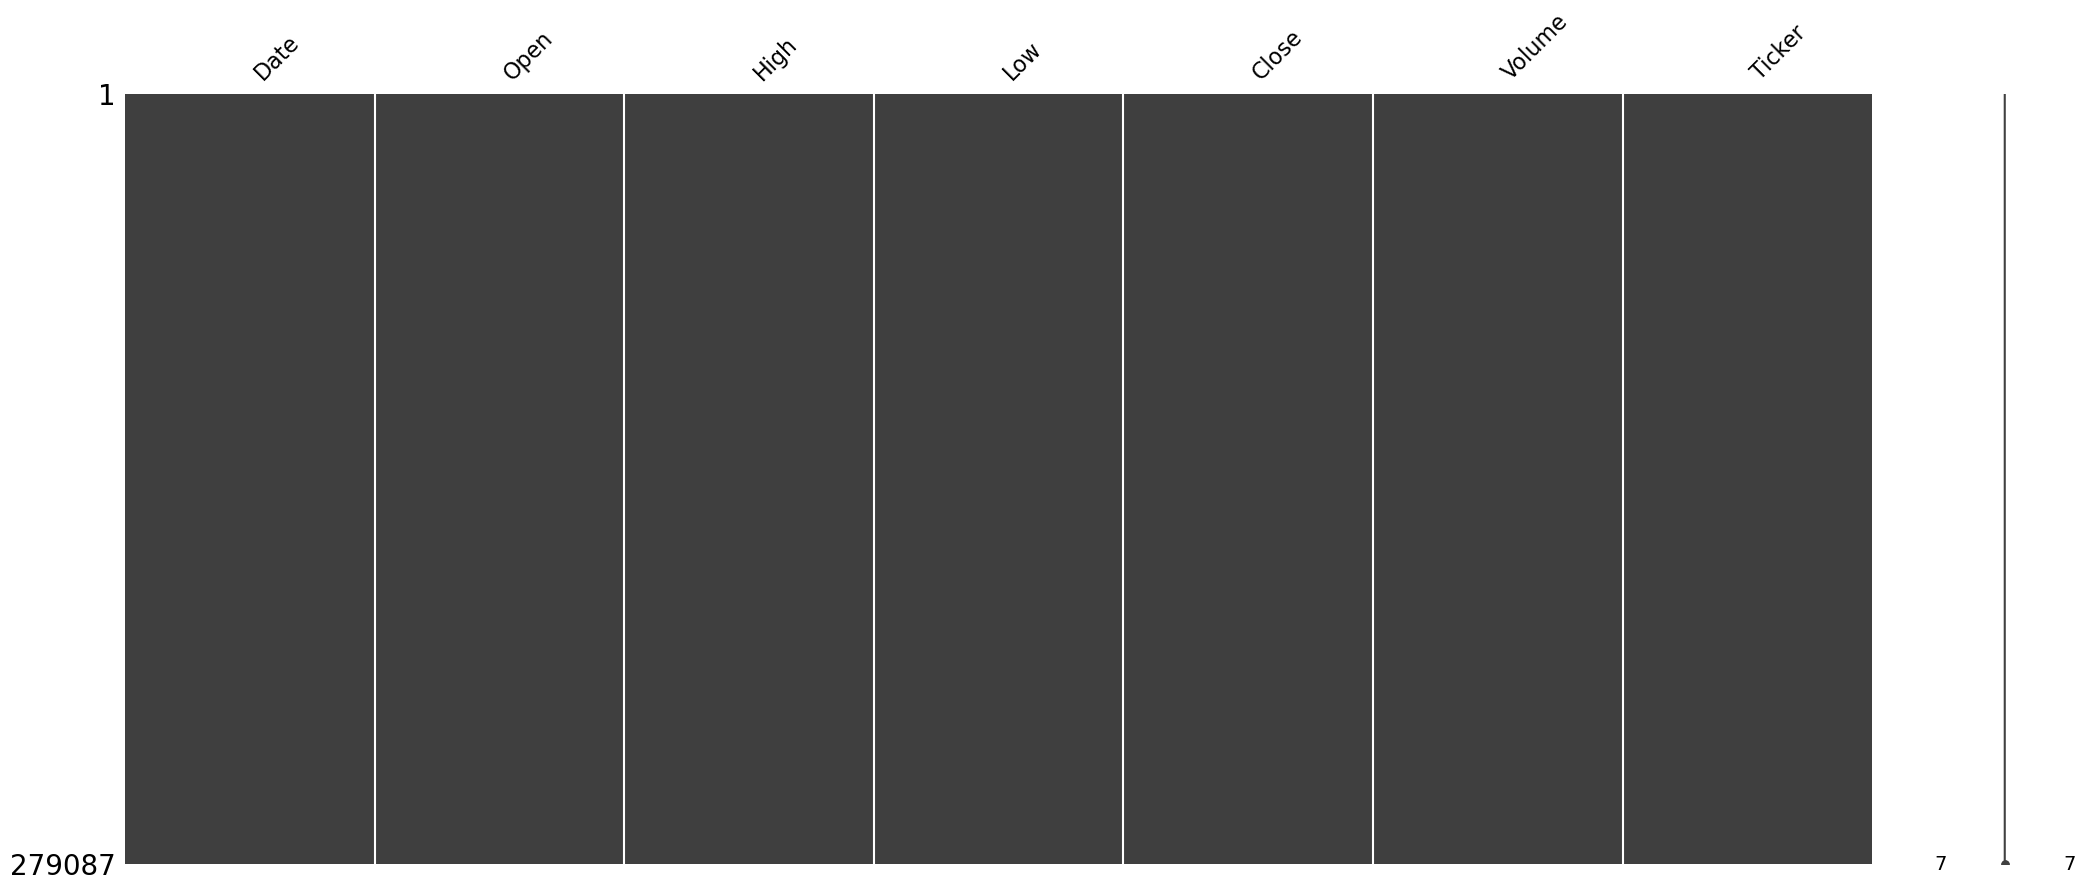

In [13]:
msno.matrix(combined_data) 

In [16]:
combined_data.dtypes

Date      datetime64[ns, America/New_York]
Open                               float64
High                               float64
Low                                float64
Close                              float64
Volume                               int64
Ticker                              object
dtype: object

In [17]:
combined_data.describe()

,Open,High,Low,Close,Volume
count,279087.000000,279087.000000,279087.000000,279087.000000,2.790870e+05
mean,647.009303,652.860285,644.411532,648.876143,2.456037e+08
std,3005.084344,3021.986222,2986.681527,3005.345057,8.398031e+08
min,0.000000,0.035600,0.033318,0.035360,0.000000e+00
25%,1.744435,2.058634,2.002060,2.031050,2.598350e+06
50%,14.802688,16.722516,16.313829,16.516001,7.736700e+06
75%,88.172052,95.690002,94.059998,94.889999,5.054890e+07
max,39774.058594,39889.050781,39589.230469,39781.371094,1.162119e+10


In [19]:
combined_data.notna().sum()

Date      279087
Open      279087
High      279087
Low       279087
Close     279087
Volume    279087
Ticker    279087
dtype: int64

In [20]:
tickers = combined_data['Ticker'].unique()

In [21]:
predictions_2024 = {}

for ticker in tickers:
    # Filter data for the current ticker
    ticker_df = combined_data[combined_data['Ticker'] == ticker]
    
    # Splitting into features (X) and target variable (y)
    X = ticker_df[['Open', 'High', 'Low', 'Close', 'Volume']]
    y = ticker_df['Close']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define parameter grid for grid search
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [50, 100, 200],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }

    # Initialize XGBoost regressor
    xgb_model = XGBRegressor()

    # Perform grid search
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)

    # Get best parameters
    best_params = grid_search.best_params_

    # Use best model for predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Model evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Performance metrics for {ticker}:")
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared Score:", r2)

    # Prediction for 2024
    X_2024 = ticker_df.tail(1)[['Open', 'High', 'Low', 'Close', 'Volume']]
    predicted_price_2024 = best_model.predict(X_2024)
    predictions_2024[ticker] = predicted_price_2024[0]


Performance metrics for AAPL:
Mean Squared Error (MSE): 0.30594802635980894
Mean Absolute Error (MAE): 0.16191400206497214
R-squared Score: 0.9998292164376335
Performance metrics for AMZN:
Mean Squared Error (MSE): 0.16684728311810212
Mean Absolute Error (MAE): 0.17907027510606502
R-squared Score: 0.9999366126894869
Performance metrics for TSLA:
Mean Squared Error (MSE): 1.3869794867965493
Mean Absolute Error (MAE): 0.47280334272136576
R-squared Score: 0.9998627461391146
Performance metrics for MSFT:
Mean Squared Error (MSE): 1.772852202109965
Mean Absolute Error (MAE): 0.5010664587025228
R-squared Score: 0.9997392984106299
Performance metrics for GOOGL:
Mean Squared Error (MSE): 0.08148336457999818
Mean Absolute Error (MAE): 0.15760230365857528
R-squared Score: 0.9999508507057796
Performance metrics for META:
Mean Squared Error (MSE): 2.988683177444095
Mean Absolute Error (MAE): 1.0541490462157794
R-squared Score: 0.9997032983844749
Performance metrics for JPM:
Mean Squared Error (MSE

In [22]:
print("\nPredicted stock prices for the end of 2024:")
for ticker, price in predictions_2024.items():
    print(f"{ticker}: {price}")


Predicted stock prices for the end of 2024:
AAPL: 169.54434204101562
AMZN: 180.0228271484375
TSLA: 170.93943786621094
MSFT: 408.9819030761719
GOOGL: 149.3272247314453
META: 495.15216064453125
JPM: 182.23802185058594
JNJ: 155.11192321777344
XOM: 114.37541961669922
NVDA: 819.52880859375
GE: 173.6564178466797
KO: 60.43007278442383
F: 12.790552139282227
IBM: 178.1527862548828
PG: 159.6947479248047
MMM: 105.41107940673828
AXP: 218.19606018066406
CVX: 157.01458740234375
T: 17.007158279418945
MCD: 278.96319580078125
^GSPC: 5183.74609375
^DJI: 39260.609375
^IXIC: 16298.677734375
^RUT: 2097.926513671875
